In [36]:
import pandas as pd

# prefix_dir = "/home/john/ZouLab_Code/RNASeq/featureCountsData/HelasRNA_Tx_14_cleanedData_HS_GRCh38p14"
countstable = "/home/john/ZouLab_Code/RNASeq/featureCountsData/HPA_GRCh38p14/Countstable.txt"

## 获取read counts
df = pd.read_csv(countstable, sep="\t", header=0)
df.set_index(df.columns[0], inplace=True)
df['Ensembl'] = df.index.str.replace(r'\..*', '', regex=True)
featureCounts_meta = df.iloc[:, :]

featureCounts_meta = featureCounts_meta.rename(columns={'HPAA1.bam': 'HPAA1', 'HPAA2.bam': 'HPAA2', 'HPAA3.bam': 'HPAA3',
                                                        'HPAD1.bam': 'HPAD1', 'HPAD2.bam': 'HPAD2', 'HPAD3.bam': 'HPAD3',
                                                        'HPAT1.bam': 'HPAT1', 'HPAT2.bam': 'HPAT2', 'HPAT3.bam': 'HPAT3',
                                                        })

# featureCounts_meta = featureCounts_meta.rename(columns={'HA4.bam': 'HA4', 'HA5.bam': 'HA5', 'HA6.bam': 'HA6',
#                                                         'HD7.bam': 'HD7', 'HD8.bam': 'HD8', 'HD9.bam': 'HD9',
#                                                         'HT1.bam': 'HT1', 'HT2.bam': 'HT2', 'HT3.bam': 'HT3',
#                                                         })

# featureCounts_meta = featureCounts_meta.rename(columns={'EcSA3.bam': 'EcSA3', 'EcSD2.bam': 'EcSD2', 'EcST1.bam': 'EcST1'})


# FC_meta_filted = FC_selectES2TD[FC_selectES2TD.iloc[:,5:14].sum(axis=1) > 50]

FC_select4HNERIP = featureCounts_meta.loc[ :, ['Chr', 'Start', 'End', 'Strand', 'Length', 'HPAA1', 'HPAA2', 'HPAA3', 'HPAD1', 'HPAD2', 'HPAD3', 'HPAT1', 'HPAT2', 'HPAT3', 'Ensembl']]
# FC_select4HNERIP = featureCounts_meta.loc[ :, ['Chr', 'Start', 'End', 'Strand', 'Length', 'EcSA3', 'EcSD2', 'EcST1', 'Ensembl']]
FC_meta_filted = FC_select4HNERIP[FC_select4HNERIP.iloc[:,5:14].sum(axis=1) > 10]  
# FC_meta_filted = FC_select4HNERIP[FC_select4HNERIP.iloc[:,5:10].sum(axis=1) > 10]  ## FC_selectES2TD
for column in FC_select4HNERIP.iloc[:,5:14].columns:
    print(column)

aim_path = '/home/john/ZouLab_Code/RNASeq/Deseq2AnalResult/HPA_GRCh38p14/HPA'
FC_meta_filted.to_csv(aim_path + "_filted.csv")

HPAA1
HPAA2
HPAA3
HPAD1
HPAD2
HPAD3
HPAT1
HPAT2
HPAT3


### id mapping

In [37]:
### geneid map 
import pandas as pd
def Matrix_ID_mapping(data:pd.DataFrame,gene_ref_path:str)->pd.DataFrame:
    pair=pd.read_csv(gene_ref_path,sep='\t',index_col=0)
    ret_gene=list(set(data['Ensembl'].tolist()) & set(pair.index.tolist()))
    data = data.loc[data['Ensembl'].isin(ret_gene)]
    data_filted=data_drop_duplicates_index(data)
    new_index=[]
    for i in data_filted['Ensembl']:
        a=pair.loc[i,'symbol']
        if str(a)=='nan':
            new_index.append(i)
        else:
            new_index.append(a)
    data_filted['Symbol']=new_index
    return data_filted

def data_drop_duplicates_index(data:pd.DataFrame)->pd.DataFrame:
    data = data.loc[data.sum(axis=1, numeric_only=True).sort_values(ascending=False).index]
    data = data.loc[~data.index.duplicated(keep='first')]
    return data


mark_path = "/home/john/ZouLab_Code/RNASeq/reference/Ensemble2Symbol.txt"
# mark_path = "/home/john/ZouLab_Code/RNASeq/reference/GCF5845_bacter/gene_locus_mapping.txt"

mark_type_path = '/home/john/ZouLab_Code/RNASeq/reference/Ensemble2type.txt'
# mark_type_path = '/home/john/ZouLab_Code/RNASeq/reference/Ensemble2type_GCF.txt'

# FC_meta_filted = pd.read_csv('/home/john/ZouLab_Code/RNASeq/Deseq2AnalResult/H4RIP/H4RIP_mrna_counts_cpm.csv')

mapped_data = Matrix_ID_mapping(FC_meta_filted, mark_path)
mapped_data.reset_index(inplace=True)
mapped_data_dedupl = mapped_data.drop_duplicates(subset='Symbol', keep='first')

gene_id_to_name = pd.read_csv(mark_type_path, sep='\t', names=['Ensembl', 'gene_biotype'])    ## 或gene_type
print(gene_id_to_name)
gene_types = []
for ensembl in mapped_data_dedupl['Geneid']:
    gene_type = gene_id_to_name.loc[gene_id_to_name['Ensembl'] == ensembl, 'gene_biotype'].values
    if len(gene_type) > 0:
        gene_types.append(gene_type[0])
    else:
        gene_types.append('Unknown')

mapped_data_dedupl['gene_biotype'] = gene_types
# aim_path = '/home/john/ZouLab_Code/RNASeq/Deseq2AnalResult/H4RIP/H4RIP'
mapped_data_dedupl.to_csv(aim_path + '_counts.csv', index=False)
# mapped_data_dedupl = pd.read_csv(aim_path + '_counts.csv')
### '/home/john/TritonX114_RNA/featureCount/Deseq2AnalResult/bwa/ES-2/ES-2_counts.csv'

### caculate the cpm
sample_cpm = mapped_data_dedupl.iloc[:, 6:15]
# sample_cpm = mapped_data_dedupl.iloc[:, 6:9]
print(mapped_data_dedupl.columns)
sample_cpm_copy = sample_cpm.copy()
for column in sample_cpm_copy.columns:
    print(column)
    sum_A = sample_cpm_copy[column].sum()
    sample_cpm_copy[column] = (sample_cpm_copy[column] / sum_A) * 1000000
    
mapped_data_dedupl_copy = mapped_data_dedupl.copy()
mapped_data_dedupl_copy.iloc[:, 6:15] = sample_cpm_copy
# mapped_data_dedupl = sample_cpm_copy
mapped_data_dedupl_copy.to_csv(aim_path + '_mrna_counts_cpm.csv', index=False)
mapped_data_dedupl.set_index('Geneid', inplace=True)

                 Ensembl                        gene_biotype
0         Gene stable ID                              symbol
1      ENSG00000290825.1                              lncRNA
2      ENSG00000223972.6  transcribed_unprocessed_pseudogene
3      ENSG00000227232.6              unprocessed_pseudogene
4      ENSG00000278267.1                               miRNA
...                  ...                                 ...
63082  ENSG00000198695.2                      protein_coding
63083  ENSG00000210194.1                             Mt_tRNA
63084  ENSG00000198727.2                      protein_coding
63085  ENSG00000210195.2                             Mt_tRNA
63086  ENSG00000210196.2                             Mt_tRNA

[63087 rows x 2 columns]
Index(['Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length', 'HPAA1', 'HPAA2',
       'HPAA3', 'HPAD1', 'HPAD2', 'HPAD3', 'HPAT1', 'HPAT2', 'HPAT3',
       'Ensembl', 'Symbol', 'gene_biotype'],
      dtype='object')
HPAA1
HPAA2
HPAA3
HPAD1
HPA

### PCA

Empty DataFrame
Columns: [HPAA1, HPAA2, HPAA3, HPAD1, HPAD2, HPAD3, HPAT1, HPAT2, HPAT3]
Index: []
        0       1       2       3      4      5      6      7      8      \
HPAA1  811706  318598  176564  152256  77596  74830  58436  69734  51602   
HPAA2  753370  297202  158400  137580  66174  67480  51724  58681  45562   
HPAA3  825149  328022  178450  162232  76260  77412  63438  68430  55314   
HPAD1  125042   53598   21146   19680   8496   9942  14392   7698  11406   
HPAD2  332884  143300   54930   54286  23486  24754  38908  21060  32980   
HPAD3  281080  120904   47418   49652  19780  20550  31800  18166  27044   
HPAT1  716624  289477  158560  136182  71924  72406  56946  62588  48790   
HPAT2  686355  267424  150370  130160  67160  64086  56030  56912  49804   
HPAT3  674897  271312  145160  132854  62610  60920  52422  57376  45278   

       9      ...  21689  21690  21691  21692  21693  21694  21695  21696  \
HPAA1      2  ...      2      0      0      2      4      6    

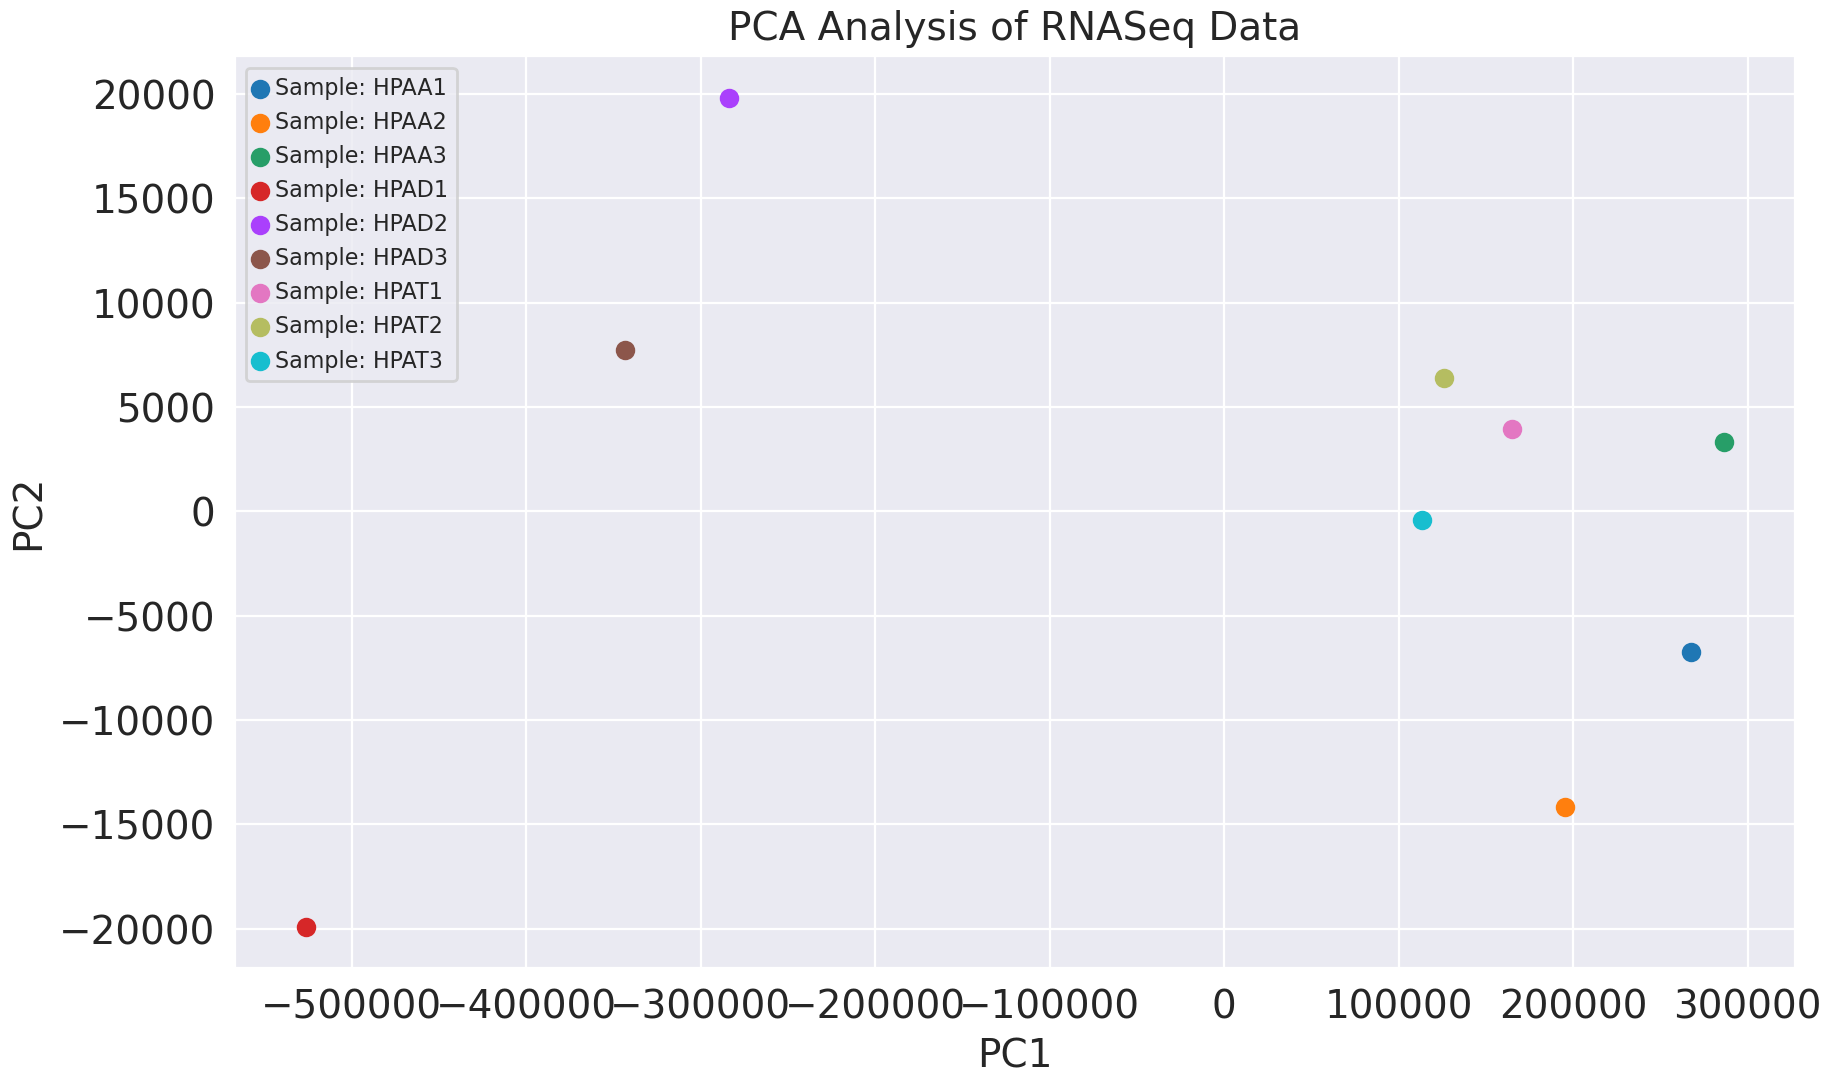

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

# data_path = "/home/john/TritonX114_RNA/featureCount/Deseq2AnalResult/bwa/Hela/Hela_counts.csv"
data_path = aim_path + "_counts.csv"
sample_df = pd.read_csv(data_path)
selected_columns = ['HPAA1', 'HPAA2', 'HPAA3', 'HPAD1', 'HPAD2', 'HPAD3', 'HPAT1', 'HPAT2', 'HPAT3']
# selected_columns = ['BwA3', 'BwD2', 'BwT1']
anal_data = sample_df[selected_columns]
rows_with_nan = anal_data[anal_data.isnull().any(axis=1)]
print(rows_with_nan)
anal_data = anal_data.dropna()

pca = PCA(n_components=2)
transformed_data = pca.fit_transform(anal_data.T)
print(anal_data.T)

sns.set_style('darkgrid')
sample = anal_data.T
fig, ax = plt.subplots(figsize=(10, 6))
# print(sample.index)
for i, component in enumerate(transformed_data[:], start=1):
    ax.scatter(component[0], component[1], label=f'Sample: {sample.index[i-1]}' )
ax.legend(loc='upper left', prop={'size': 8})
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])

ax.set_title('PCA Analysis of RNASeq Data')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

output_path = aim_path + "_PCA.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

### do differential expression analysis

In [39]:
import pandas as pd
import numpy as np
# import omicverse as ov
# dds=ov.bulk.pyDEG(data)

def deg_analysis(data:pd.DataFrame,group1:list,group2:list,
                    method:str='DEseq2',alpha:float=0.05,n_cpus:int=8,
                    cooks_filter:bool=True, independent_filter:bool=True)->pd.DataFrame:
        from pydeseq2.dds import DeseqDataSet
        from pydeseq2.ds import DeseqStats
        if method=='DEseq2':
            if data.isnull().values.any() or np.isinf(data).values.any():
                raise ValueError("Input data contains NaN or Inf values.")
            import pydeseq2
            counts_df=data[group1+group2].T
            clinical_df=pd.DataFrame(index=group1+group2)
            clinical_df['condition']=['Treatment']*len(group1)+['Control']*len(group2)
            if pydeseq2.__version__<='0.4.1':
                dds = DeseqDataSet(
                    counts=counts_df,
                    metadata=clinical_df,
                    design_factors="condition",  # compare samples based on the "condition"
                    # ref_level=["condition", "Control"],
                    # column ("B" vs "A"),
                    # refit_cooks=True
                )
            dds.fit_size_factors()
            dds.fit_genewise_dispersions()
            dds.fit_dispersion_trend()
            dds.fit_dispersion_prior()
            print(
                f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}"
            )
            dds.fit_MAP_dispersions()
            dds.fit_LFC()
            dds.calculate_cooks()
            if dds.refit_cooks:
                # Replace outlier counts
                dds.refit()
            stat_res = DeseqStats(dds, alpha=alpha, cooks_filter=cooks_filter, independent_filter=independent_filter)
            stat_res.run_wald_test()
            
            if stat_res.cooks_filter:
                stat_res._cooks_filtering()
            if stat_res.independent_filter:
                stat_res._independent_filtering()
            else:
                stat_res._p_value_adjustment()

            stat_res.summary()
            result=stat_res.results_df
            result['log2(BaseMean)']=np.log2(result['baseMean']+1)
            result['-log10(pvalue)'] = -np.log10(result['pvalue'])
            result['-log10(padj)'] = -np.log10(result['padj'])
            result['State']='normal'
            result.loc[result['padj']<alpha,'State']='sig'
            return result
        else:
            raise ValueError('The method is not supported.')

## 'HT1', 'HT2', 'HT3', 'HA1', 'HA2', 'HA3', 'HD1', 'HD2', 'HD3'
# dds = mapped_data_dedupl.loc[ :, ['HT1', 'HT2', 'HT3', 'HA1', 'HA2', 'HA3']]
# treatment_groups = ['HA1', 'HA2', 'HA3']
# control_groups = ['HT1', 'HT2', 'HT3']

# 'ET1', 'ET2', 'ET3', 'EA1', 'EA2', 'EA3', 'ED1', 'ED2', 'ED3'
# ['HSA1', 'HSA2', 'HSA3', 'HSD1', 'HSD2', 'HSD3', 'HST1', 'HST2', 'HST3']
# dds = mapped_data_dedupl.loc[ :, ['BwA3', 'BwD2', 'BwT1']]
dds = mapped_data_dedupl.loc[ :, ['HPAA1', 'HPAA2', 'HPAA3', 'HPAD1', 'HPAD2', 'HPAD3', 'HPAT1', 'HPAT2', 'HPAT3']]
treatment_groups = ['HPAA1', 'HPAA2', 'HPAA3']
control_groups = ['HPAT1', 'HPAT2', 'HPAT3']

# ### Treat vs Contro file 
dds_analed = deg_analysis(dds, treatment_groups, control_groups)
result_dds_normalized = pd.concat([dds_analed, dds, mapped_data_dedupl.loc[:, ['Ensembl', 'Symbol', 'gene_biotype']]], axis=1)
result_dds_normalized.reset_index(inplace=True)
pvalue_zero_rows = result_dds_normalized[result_dds_normalized['pvalue'] == 0]

deg_path = aim_path + "_TvsA_DEG.csv"
save_path_DEG = aim_path + "_TvsA_DEG.png"
save_path_PathEnrich = aim_path + "_DEG_TvsA_PathwayEnrich.png"
save_path_Multy = aim_path + "_DEG_TvsA_MultyPathway.png"
sava_path_deg_BMFC = aim_path + "_DEG_TvsA_BMFC.png"
result_dds_normalized.to_csv(deg_path, index=False)


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.79 seconds.

Fitting dispersion trend curve...
... done in 2.72 seconds.

Fitting MAP dispersions...


logres_prior=0.7642900992889561, sigma_prior=0.25


... done in 0.88 seconds.

Fitting LFCs...
... done in 0.85 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Treatment vs Control


... done in 0.59 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
ENSG00000210082.2,739231.259550,0.099684,0.025329,3.935550,0.000083,0.200000
ENSG00000211459.2,293204.322491,0.085948,0.027859,3.085062,0.002035,0.986840
ENSG00000198886.2,160023.786354,0.074029,0.023289,3.178671,0.001480,0.925752
ENSG00000198804.2,140774.743993,0.073828,0.025318,2.916026,0.003545,0.999015
ENSG00000198888.2,69748.253103,0.022087,0.030777,0.717640,0.472979,0.999015
...,...,...,...,...,...,...
ENSG00000283813.1,2.331107,0.313089,1.685086,0.185800,0.852602,0.999015
ENSG00000276176.1,2.370185,-2.697424,1.780070,-1.515347,0.129685,0.999015
ENSG00000284585.1,2.471519,-4.805683,4.163979,-1.154108,0.248456,0.999015


### visualize the DEG result

                        baseMean  log2FoldChange     lfcSE      stat  \
Geneid                                                                 
ENSG00000210082.2  739231.259550        0.099684  0.025329  3.935550   
ENSG00000211459.2  293204.322491        0.085948  0.027859  3.085062   
ENSG00000198886.2  160023.786354        0.074029  0.023289  3.178671   
ENSG00000198804.2  140774.743993        0.073828  0.025318  2.916026   
ENSG00000198888.2   69748.253103        0.022087  0.030777  0.717640   

                     pvalue      padj  log2(BaseMean)  -log10(pvalue)  \
Geneid                                                                  
ENSG00000210082.2  0.000083  0.200000       19.495668        4.080888   
ENSG00000211459.2  0.002035  0.986840       18.161552        2.691415   
ENSG00000198886.2  0.001480  0.925752       17.287936        2.829879   
ENSG00000198804.2  0.003545  0.999015       17.103039        2.450358   
ENSG00000198888.2  0.472979  0.999015       16.089890    

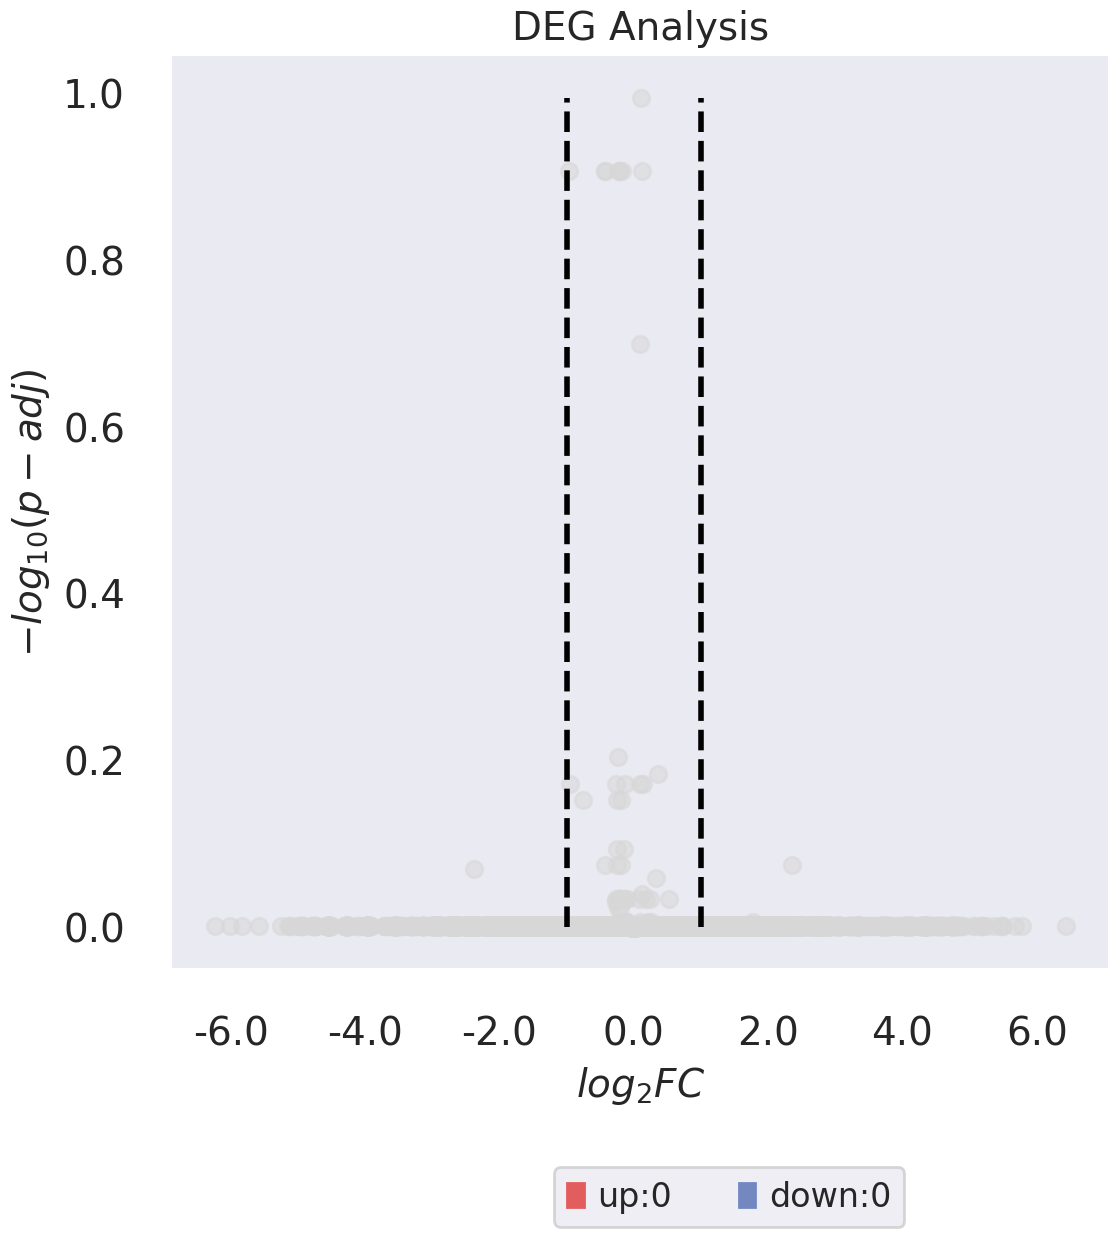

In [45]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

def volcano(result,p_name='padj',fc_name='log2FoldChange',pval_max=None,FC_max=None,
            figsize:tuple=(4,4),title:str='',titlefont:dict={'weight':'normal','size':14,},
                    up_color:str='#e25d5d',down_color:str='#7388c1',normal_color:str='#d7d7d7',
                    up_fontcolor:str='#e25d5d',down_fontcolor:str='#7388c1',normal_fontcolor:str='#d7d7d7',
                    legend_bbox:tuple=(0.8, -0.2),legend_ncol:int=2,legend_fontsize:int=12,
                    plot_genes:list=None,plot_genes_num:int=10,plot_genes_fontsize:int=10,
                    ticks_fontsize:int=12,pval_threshold:float=0.05,fc_max:float=1.,fc_min:float=-1.,
                    ax = None,):
    result=result.copy()
    result['-log(p-adj)']=-np.log10(result[p_name])
    result['log2FC']= result[fc_name].copy()
    
    result['sig']='normal'
    result.loc[((result['log2FC']>fc_max)&(result['padj']<pval_threshold)),'sig']='up'
    result.loc[((result['log2FC']<fc_min)&(result['padj']<pval_threshold)),'sig']='down'
    
    if ax==None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(x=result[result['sig']=='normal']['log2FC'],
            y=result[result['sig']=='normal']['-log(p-adj)'],
            color=normal_color, alpha=.5 )
    #接着绘制上调基因
    ax.scatter(x=result[result['sig']=='up']['log2FC'],
            y=result[result['sig']=='up']['-log(p-adj)'],
            color=up_color, alpha=.5 )
    #绘制下调基因
    ax.scatter(x=result[result['sig']=='down']['log2FC'],
            y=result[result['sig']=='down']['-log(p-adj)'],
            color=down_color, alpha=.5 )

    # ax.plot([result['log2FC'].min(),result['log2FC'].max()],#辅助线的x值起点与终点
    #         [-np.log10(pval_threshold),-np.log10(pval_threshold)],#辅助线的y值起点与终点
    #         linewidth=2, linestyle="--", color='black')
    
    ax.plot([fc_max,fc_max],
            [result['-log(p-adj)'].min(),result['-log(p-adj)'].max()],
            linewidth=2, linestyle="--", color='black')
    
    ax.plot([fc_min,fc_min],
            [result['-log(p-adj)'].min(),result['-log(p-adj)'].max()],
            linewidth=2, linestyle="--", color='black')
    #设置横标签与纵标签
    ax.set_ylabel(r'$-log_{10}(p-adj)$',titlefont)                                    
    ax.set_xlabel(r'$log_{2}FC$',titlefont)
    #设置标题
    ax.set_title(title,titlefont)

    #绘制图注
    #legend标签列表，上面的color即是颜色列表
    labels = ['up:{0}'.format(len(result[result['sig']=='up'])),
            'down:{0}'.format(len(result[result['sig']=='down']))]  

    color = [up_color,down_color]
    patches = [mpatches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color))] 

    ax.legend(handles=patches,
        bbox_to_anchor=legend_bbox, 
        ncol=legend_ncol,
        fontsize=legend_fontsize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    ax.set_xticks([round(i,2) for i in ax.get_xticks()[1:-1]],#获取x坐标轴内容
        [round(i,2) for i in ax.get_xticks()[1:-1]],#更新x坐标轴内容
        fontsize=ticks_fontsize,
        fontweight='normal'
        )

    plt.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))


    from adjustText import adjust_text
    import adjustText

    if plot_genes is not None:
        hub_gene=plot_genes
    elif (plot_genes is None) and (plot_genes_num is None):
        return ax
    else:
        up_result=result.loc[result['sig']=='up']
        down_result=result.loc[result['sig']=='down']
        hub_gene=up_result.sort_values(p_name).index[:plot_genes_num//2].tolist()+down_result.sort_values(p_name).index[:plot_genes_num//2].tolist()

    color_dict={
    'up':up_fontcolor,
        'down':down_fontcolor,
        'normal':normal_fontcolor
    }

    texts=[ax.text(result.loc[i,'log2FC'], 
        result.loc[i,'-log(p-adj)'],
        result.loc[i, 'Symbol'],
        fontdict={'size':plot_genes_fontsize,'weight':'bold','color':color_dict[result.loc[i,'sig']]}
        ) for i in hub_gene]

    if adjustText.__version__<='0.8':
        adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)
    else:
        adjust_text(texts,only_move={"text": "xy", "static": "xy", "explode": "xy", "pull": "xy"},
                    arrowprops=dict(arrowstyle='->', color='red'))
    return ax

deg = pd.read_csv(deg_path, index_col=0)
print(deg.head())
ax = volcano(deg, p_name='padj',title='DEG Analysis', figsize=(6, 6), 
                plot_genes_num=20, plot_genes_fontsize=12, fc_max=1, fc_min=-1)

plt.savefig(save_path_DEG, bbox_inches='tight', dpi=300)

### visualize the specific genes

In [41]:
## 色卡
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']

red_color=['#F0C3C3','#E07370','#CB3E35','#A22E2A','#5A1713','#D3396D','#DBC3DC','#85539B','#5C2B80','#5C4694']
green_color=['#91C79D','#8FC155','#56AB56','#2D5C33','#BBCD91','#6E944A','#A5C953','#3B4A25','#010000']
orange_color=['#EFBD49','#D48F3E','#AC8A3E','#7D7237','#745228','#E1C085','#CEBC49','#EBE3A1','#6C6331','#8C9A48','#D7DE61']
blue_color=['#347862','#6BBBA0','#81C0DD','#3E8CB1','#88C8D2','#52B3AD','#265B58','#B2B0D4','#5860A7','#312C6C']
purple_color=['#823d86','#825b94','#bb98c6','#c69bc6','#a69ac9','#c5a6cc','#caadc4','#d1c3d4']

ditto_color=[
            "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2",
            "#D55E00", "#CC79A7", "#666666", "#AD7700", "#1C91D4",
            "#007756", "#D5C711", "#005685", "#A04700", "#B14380",
            "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71",
            "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C"]

In [42]:
# import random
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# from matplotlib.patches import Patch
# from typing import Tuple

# def ticks_range(x,width):
#     nticks=[]
#     pticks=[]
#     start=-(x//2)
#     end=(x//2)
#     for i in range(x//2):
#         nticks.append(start+width)
#         start+=width
#         pticks.append(end-width)
#         end-=width
#     if x%2==0:
#         ticks=nticks+pticks
#     elif x%2==1:
#         ticks=nticks+[0]+pticks
#     return ticks

# def plot_boxplot(data: pd.DataFrame, genes: list, treatment_groups: list, control_groups: list,
#                     treatment_name: str = 'Treatment', control_name: str = 'Control',
#                     figsize: tuple = (4, 3), palette: list = ["#a64d79", "#674ea7"],
#                     title: str = 'Gene Expression', fontsize: int = 12, legend_bbox: tuple = (1, 0.55),
#                     legend_ncol: int = 1) -> Tuple[plt.Figure, plt.Axes]:

#     p_data = pd.DataFrame(columns=['Value', 'Gene', 'Type'])
#     for gene in genes:
#         treatment_values = data[treatment_groups].loc[data['Symbol'] == gene, :].values
#         control_values = data[control_groups].loc[data['Symbol'] == gene, :].values
#         treatment_df = pd.DataFrame({
#             'Value': np.log1p(treatment_values[0, :]),
#             'Gene': gene,
#             'Type': treatment_name})
        
#         control_df = pd.DataFrame({
#             'Value': np.log1p(control_values[0, :]), 
#             'Gene': gene,
#             'Type': control_name})
            
#         p_data = pd.concat([p_data, treatment_df, control_df], axis=0)
#     fig,ax=boxplot(p_data,hue='Type',x_value='Gene',y_value='Value',palette=palette,
#                     figsize=figsize,fontsize=fontsize,title=title,
#                     legend_bbox=legend_bbox,legend_ncol=legend_ncol)
#     return fig,ax

# def boxplot(data, hue, x_value, y_value, width=0.6, title='',
#                 figsize=(6, 3), palette=None, fontsize=10,
#                 legend_bbox=(1, 0.55), legend_ncol=1):
#     if palette is None:
#         palette = ["#a64d79", "#674ea7"]  # 假设的默认色卡

#     hue_datas = list(set(data[hue]))
#     ticks = list(set(data[x_value]))
#     num_ticks = len(hue_datas)

#     fig, ax = plt.subplots(figsize=figsize)

#     for hue_data, hue_color, offset in zip(hue_datas, palette, ticks_range(num_ticks, width)):
#         positions = np.arange(len(ticks)) * num_ticks + offset
#         data_a = [data.loc[(data[x_value] == i) & (data[hue] == hue_data), y_value].tolist() for i in ticks]
#         b1 = ax.boxplot(data_a, positions=positions, sym='', widths=width)

#         for patch in b1['boxes'] + b1['whiskers'] + b1['caps'] + b1['medians']:
#             patch.set_color(hue_color)

#         for i, test_data in enumerate(data_a):
#             data_size = min(20, len(test_data))
#             random_data = random.sample(test_data, data_size)
#             x = np.random.normal(positions[i], 0.04, data_size)
#             ax.scatter(x, random_data, c=hue_color, alpha=0.4)

#     ax.set_xticks(range(0, len(ticks) * num_ticks, num_ticks), ticks, fontsize=fontsize)
#     yticks=ax.get_yticks()
#     ax.set_yticks(yticks[yticks>=0],fontsize=fontsize)

#     legend_elements = [
#         plt.Line2D([0], [0], color=palette[0], lw=2, label=hue_datas[0]),
#         plt.Line2D([0], [0], color=palette[1], lw=2, label=hue_datas[1])
#     ]
#     ax.legend(handles=legend_elements, bbox_to_anchor=legend_bbox, ncol=legend_ncol, fontsize=fontsize)

#     ax.set_title(title, fontsize=fontsize + 1)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(True)
#     ax.spines['left'].set_visible(True)

#     return fig, ax

# path = "/home/john/TritonX114_RNA/featureCount/Deseq2AnalResult/hisat2/Hela/Hela_DEG_DvsA.csv"
# deg = pd.read_csv(path, index_col=0)
# genelist = ['MMP1', 'EEF1A1P5']
# plg = plot_boxplot(deg, genes=genelist, treatment_groups=treatment_groups,
#             control_groups=control_groups, figsize=(2,3), fontsize=12, legend_bbox=(2,0.55))

# save_path = "/home/john/TritonX114_RNA/featureCount/Deseq2AnalResult/hisat2/Hela/Select_Gene_BoxPlot.png"
# plt.savefig(save_path, bbox_inches='tight', dpi=300)

### Pathway enrichment analysis

In [43]:
import pandas as pd
import matplotlib

def geneset_prepare(geneset_path,organism='Human'):
    go_bio_geneset=pd.read_csv(geneset_path,sep='\t\t',header=None)
    go_bio_dict={}
    if (organism == 'Mouse') or (organism == 'mouse'):
        for i in go_bio_geneset.index:
            go_bio_dict[go_bio_geneset.loc[i,0]]=[i.lower().capitalize() for i in go_bio_geneset.loc[i,1].split('\t')]
    elif (organism == 'Human') or (organism == 'human'):
        for i in go_bio_geneset.index:
            go_bio_dict[go_bio_geneset.loc[i,0]]=[i.upper() for i in go_bio_geneset.loc[i,1].split('\t')]
    else:
        for i in go_bio_geneset.index:
            go_bio_dict[go_bio_geneset.loc[i,0]]=[i for i in go_bio_geneset.loc[i,1].split('\t')]
    return go_bio_dict

def geneset_enrichment(gene_list:list,pathways_dict:dict,
                        pvalue_threshold:float=0.05,pvalue_type:str='auto',
                        organism:str='Human',description:str='None',
                        background:list=None,
                        outdir:str='./enrichr',cutoff:float=0.5)->pd.DataFrame:
    
    import gseapy as gp
    if background is None:
        if (organism == 'Mouse') or (organism == 'mouse'):
            background='mmusculus_gene_ensembl'
        elif (organism == 'Human') or (organism == 'human'):
            background='hsapiens_gene_ensembl'

    enr = gp.enrichr(gene_list=gene_list, gene_sets=pathways_dict, organism=organism, 
                    description=description, background=background, outdir=outdir, cutoff=cutoff)
    
    if pvalue_type=='auto':
        if enr.res2d.shape[0]>100:
            enrich_res=enr.res2d[enr.res2d['Adjusted P-value']<pvalue_threshold]
            enrich_res['logp']=-np.log(enrich_res['Adjusted P-value'])
        else:
            enrich_res=enr.res2d[enr.res2d['P-value']<pvalue_threshold]
            enrich_res['logp']=-np.log(enrich_res['P-value'])

    elif pvalue_type=='adjust':
        enrich_res=enr.res2d[enr.res2d['Adjusted P-value']<pvalue_threshold]
        enrich_res['logp']=-np.log(enrich_res['Adjusted P-value'])
        
    enrich_res['logc']=np.log(enrich_res['Odds Ratio'])
    enrich_res['num']=[int(i.split('/')[0]) for i in enrich_res['Overlap']]
    enrich_res['fraction']=[int(i.split('/')[0])/int(i.split('/')[1]) for i in enrich_res['Overlap']]
    return enrich_res

def plot_text_set(text, text_knock=2, text_maxsize=20):
    if len(text) <= text_maxsize:
        return text
    
    words = text.split(' ')
    formatted_text = []
    for i, word in enumerate(words):
        if i > 0 and i % text_knock == 0:
            formatted_text.append('\n')
        formatted_text.append(word)
    
    return ' '.join(formatted_text).strip()

def geneset_plot(enrich_res,num:int=10,node_size:list=[5,10,15],
                        cax_loc:list=[2, 0.55, 0.5, 0.02],cax_fontsize:int=12,
                        fig_title:str='',fig_xlabel:str='Fractions of genes',
                        figsize:tuple=(2,4),cmap:str='YlGnBu',
                        text_knock:int=5,text_maxsize:int=20,
                        bbox_to_anchor_used:tuple=(-0.45, -13),node_diameter:int=10,
                        custom_ticks:list=[5,10])->matplotlib.axes._axes.Axes:
    fig, ax = plt.subplots(figsize=figsize)
    plot_data2=enrich_res.sort_values('P-value')[:num].sort_values('logc')
    st=ax.scatter(plot_data2['fraction'],range(len(plot_data2['logc'])),
            s=plot_data2['num']*node_diameter,linewidths=1,edgecolors='black',c=plot_data2['logp'],cmap=cmap)
    ax.yaxis.tick_right()
    plt.yticks(range(len(plot_data2['fraction'])),[plot_text_set(i.split('(')[0],text_knock=text_knock,text_maxsize=text_maxsize) for i in plot_data2['Term']],
            fontsize=10,)
    plt.xticks(fontsize=12,)
    plt.title(fig_title,fontsize=12)
    plt.xlabel(fig_xlabel,fontsize=12)

    #fig = plt.gcf()
    cax = fig.add_axes(cax_loc)
    cb=fig.colorbar(st,shrink=0.25,cax=cax,orientation='horizontal')
    cb.set_label(r'$−Log_{10}(P_{adjusted})$',fontdict={'size':cax_fontsize})
    # new code to add custom ticks
    cb.set_ticks(custom_ticks)

    gl_li=[]
    for i in node_size:
        gl_li.append(ax.scatter([],[], s=i*node_diameter, marker='o', color='white',edgecolors='black'))

    plt.legend(gl_li,
        [str(i) for i in node_size],
        loc='lower left',
        ncol=3,bbox_to_anchor=bbox_to_anchor_used,
        fontsize=cax_fontsize)
    return ax

In [44]:
pathway_dict = geneset_prepare('/home/john/RNA-seq/genesets/WikiPathway_2021_Human.txt',organism='human')

deg = pd.read_csv(deg_path, index_col=0)
deg_genes= deg['Symbol'].loc[deg['State']!='normal'].tolist()

enr=geneset_enrichment(gene_list=deg_genes, pathways_dict=pathway_dict,
                        pvalue_type='auto', organism='human')

enrich_res = enr.copy()
plg = geneset_plot(enr,figsize=(2,5),fig_title='Pathway enrichment',
                    cax_loc=[2, 0.45, 0.5, 0.02],
                    
                    bbox_to_anchor_used=(-0.25, -13),node_diameter=5,
                    custom_ticks=[5,15,25,35,45,55], text_knock=3, cmap='Reds')

plt.savefig(save_path_PathEnrich, bbox_inches='tight', dpi=300)

TypeError: 'NoneType' object is not subscriptable

### Multi pathway enrichment

In [26]:
import omicverse as ov

def geneset_plot_multi(enr_dict,colors_dict,num:int=5,fontsize=10,
                        fig_title:str='Multi pathway enrichment',
                        fig_xlabel:str='Fractions of genes',
                        figsize:tuple=(2,4),cmap:str='YlGnBu',
                        text_knock:int=5,text_maxsize:int=20,ax=None,
                        ):
    from PyComplexHeatmap import HeatmapAnnotation,DotClustermapPlotter,anno_label,anno_simple,AnnotationBase
    for key in enr_dict.keys():
        enr_dict[key]['Type']=key
    enr_all=pd.concat([enr_dict[i].iloc[:num] for i in enr_dict.keys()],axis=0)
    enr_all['Term']=[plot_text_set(i.split('(')[0],text_knock=text_knock,text_maxsize=text_maxsize) for i in enr_all.Term.tolist()]
    enr_all.index=enr_all.Term
    enr_all['Term1']=[i for i in enr_all.index.tolist()]
    del enr_all['Term']

    colors=colors_dict

    left_ha = HeatmapAnnotation(
                            label=anno_label(enr_all.Type, merge=True,rotation=0,colors=colors,relpos=(1,0.8)),
                            Category=anno_simple(enr_all.Type,cmap='Set1', add_text=False,legend=False,colors=colors),
                            axis=0,verbose=0,label_kws={'rotation':45,'horizontalalignment':'left','visible':False})
    right_ha = HeatmapAnnotation(
                            label=anno_label(enr_all.Term1, merge=True,rotation=0,relpos=(0,0.5),arrowprops=dict(visible=True),
                                            colors=enr_all.assign(color=enr_all.Type.map(colors)).set_index('Term1').color.to_dict(),
                                            fontsize=fontsize,luminance=0.8,height=2), axis=0,verbose=0, orientation='right')
    if ax==None:
        fig, ax = plt.subplots(figsize=figsize) 
    else:
        ax=ax

    cm = DotClustermapPlotter(data=enr_all, x='fraction',y='Term1',value='logp',c='logp',s='num',
                                cmap=cmap,
                                row_cluster=True,#col_cluster=True,#hue='Group',
                                vmin=-1*np.log10(0.1),vmax=-1*np.log10(1e-10),
                                show_rownames=True,show_colnames=False,row_dendrogram=False,
                                col_names_side='top',row_names_side='right',
                                xticklabels_kws={'labelrotation': 30, 'labelcolor': 'blue','labelsize':fontsize},
                                left_annotation=left_ha,right_annotation=right_ha,
                                spines=False,
                                row_split=enr_all.Type,# row_split_gap=1,
                                verbose=1,legend_gap=10,
                                #dot_legend_marker='*',
                                xlabel='Fractions of genes',xlabel_side="bottom",
                                xlabel_kws=dict(labelpad=8,fontweight='normal',fontsize=fontsize+2) )
    tesr=plt.gcf().axes
    for ax in plt.gcf().axes:
        if hasattr(ax, 'get_xlabel'):
            if ax.get_xlabel() == 'Fractions of genes':  # 假设 colorbar 有一个特定的标签
                cbar = ax
                cbar.grid(False)
            if ax.get_ylabel() == 'logp':  # 假设 colorbar 有一个特定的标签
                cbar = ax
                cbar.tick_params(labelsize=fontsize+2)
                cbar.set_ylabel(r'$−Log_{10}(P_{adjusted})$',fontsize=fontsize+2)
                cbar.grid(False)
    return ax


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 84.30733808133948
Plotting legends..
Estimated legend width: 9.879166666666666 mm


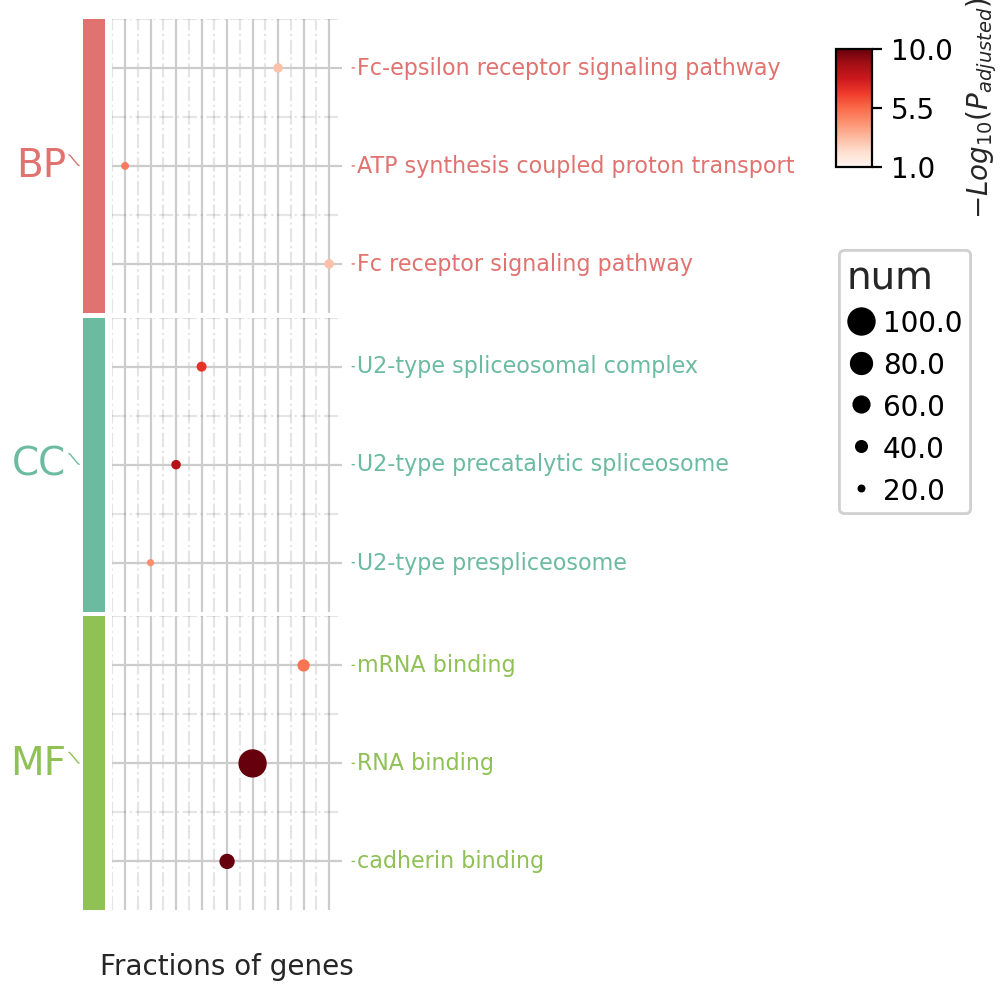

In [27]:
deg = pd.read_csv(deg_path, index_col=0)
deg_genes= deg['Symbol'].loc[deg['State']!='normal'].tolist()

pathway_dict=geneset_prepare('/home/john/RNA-seq/genesets/GO_Biological_Process_2021.txt',organism='human')
enr_go_bp=geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='human')
pathway_dict=geneset_prepare('/home/john/RNA-seq/genesets/GO_Molecular_Function_2021.txt',organism='human')
enr_go_mf=geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='human')
pathway_dict=geneset_prepare('/home/john/RNA-seq/genesets/GO_Cellular_Component_2021.txt',organism='human')
enr_go_cc=geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='human')

enr_dict={'BP':enr_go_bp, 'MF':enr_go_mf,'CC':enr_go_cc}
duplicated_rows = df.duplicated()
duplicated_columns = df.columns[df.columns.duplicated()]
colors_dict={ 'BP':red_color[1], 'MF':green_color[1], 'CC':blue_color[1] }

plg = geneset_plot_multi(enr_dict,colors_dict,num=3, figsize=(2,5),
                            text_knock=5,fontsize=8, cmap='Reds')


plt.savefig(save_path_Multy, bbox_inches='tight', dpi=300)

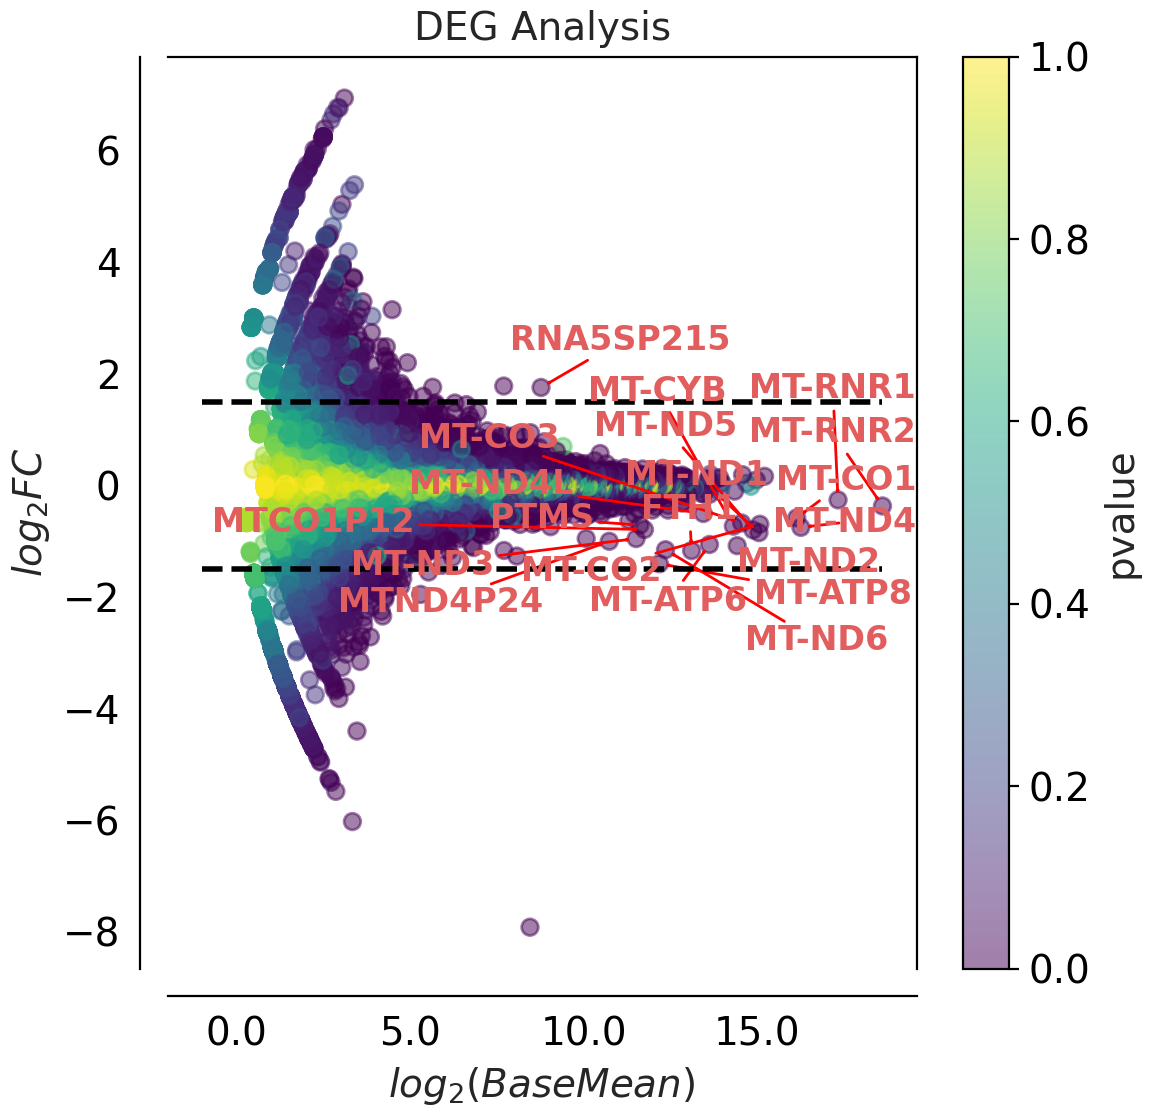

In [28]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

def volcano(result,p_name='pvalue',fc_name='log2FoldChange',bm_name='log2(BaseMean)',pval_max=None,FC_max=None,
            figsize:tuple=(4,4),title:str='',titlefont:dict={'weight':'normal','size':14,},
                    up_color:str='#e25d5d',down_color:str='#7388c1',normal_color:str='#d7d7d7',
                    up_fontcolor:str='#e25d5d',down_fontcolor:str='#7388c1',normal_fontcolor:str='#d7d7d7',
                    legend_bbox:tuple=(0.8, -0.2),legend_ncol:int=2,legend_fontsize:int=12,
                    plot_genes:list=None,plot_genes_num:int=10,plot_genes_fontsize:int=10,
                    ticks_fontsize:int=12,pval_threshold:float=0.05,fc_max:float=1.,fc_min:float=-1.,
                    ax = None,):

    result=result.copy()
    result['-log(p-adj)']=-np.log10(result[p_name])
    result['log2FC']= result[fc_name].copy()
    result['log2(BaseMean)'] = result[bm_name].copy()



    cmap = plt.cm.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=0, vmax=1)

    if ax==None:
        fig, ax = plt.subplots(figsize=figsize)

    scatter = ax.scatter(x=result['log2(BaseMean)'],
                y=result['log2FC'],
                c=result[p_name],
                cmap=cmap,
                norm=norm,
                alpha=.5 )
            

    ax.plot([result['log2(BaseMean)'].min()-1,result['log2(BaseMean)'].max()],
            [fc_max,fc_max],
            linewidth=2, linestyle="--", color='black')
    ax.plot([result['log2(BaseMean)'].min()-1,result['log2(BaseMean)'].max()],
            [fc_min,fc_min],
            linewidth=2, linestyle="--", color='black')
    

    #设置横标签与纵标签
    ax.set_ylabel(r'$log_{2}FC$',titlefont)                                    
    ax.set_xlabel(r'$log_{2}(BaseMean)$',titlefont)
    #设置标题
    ax.set_title(title,titlefont)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('pvalue')

    ax.set_xticks([round(i,2) for i in ax.get_xticks()[1:-1]],#获取x坐标轴内容
        [round(i,2) for i in ax.get_xticks()[1:-1]],#更新x坐标轴内容
        fontsize=ticks_fontsize,
        fontweight='normal'
        )

    texts = []
    top_genes = result.nsmallest(plot_genes_num, p_name)
    for gene in top_genes.itertuples():
        text = ax.text(gene._7, gene.log2FC, gene.Symbol, fontsize=plot_genes_fontsize, ha='right', va='bottom', color = up_color, fontweight='bold')
        texts.append(text)
    
    from adjustText import adjust_text
    import adjustText
    
    if adjustText.__version__ <= '0.8':
        adjust_text(texts, only_move={'text': 'xy'}, arrowprops=dict(arrowstyle='->', color='red'))
    else:
        adjust_text(texts, only_move={"text": "xy", "static": "xy", "explode": "xy", "pull": "xy"},
                    arrowprops=dict(arrowstyle='->', color='red'))
        
    plt.grid(False)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return ax

deg = pd.read_csv(deg_path, index_col=0)
ax = volcano(deg,title='DEG Analysis', figsize=(6, 6), 
                plot_genes_num=20, plot_genes_fontsize=12, fc_max=1.5, fc_min=-1.5)
plt.savefig(sava_path_deg_BMFC, bbox_inches='tight', dpi=300)